# Parte 1 - Gerando Redes Eficientes e Robustas usando MCMC

In [1]:
%%capture
!pip install networkx
!pip install seaborn

In [2]:
import numpy as np
import random as rd
import pandas as pd
import networkx as nx
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.sparse.csgraph import floyd_warshall
from scipy.sparse import csr_matrix
import statistics as stats

from utils.log import Log

In [3]:
def draw(grafo):
    nx.draw(nx.Graph(grafo), with_labels=True)

## Definindo o algoritmo Metropolis Hastings

In [4]:
def gerar_grafo_inicial(n_vertices, n_arestas):
    grafo = np.zeros((n_vertices, n_vertices))

    # Cria grafo circular
    for vertice in range(n_vertices):
        proximo = (vertice + 1) % n_vertices
        if proximo > vertice:
            grafo[proximo, vertice] = 1
        else:
            grafo[vertice, proximo] = 1
    
    arestas_restantes = n_arestas - n_vertices
    
    # Cria lista de arestas ainda não existentes
    possiveis = list()
    for i in range(n_vertices):
        for j in range(i):
            if grafo[i,j] == 0:
                possiveis.append((i,j))
    
    # Escolhe arestas aleatorias não existentes para criar
    for aresta in rd.sample(possiveis, arestas_restantes):
        grafo[aresta] = 1
    
    return grafo

In [5]:
import itertools
import random as rd

def propoe_novo_grafo(grafo):
    n_vertices = grafo.shape[0]
    arestas = list()
    nao_arestas = list()
    for i in range(n_vertices):
        for j in range(i):
            if grafo[i,j] == 1:
                arestas.append((i,j))
            else:
                nao_arestas.append((i,j))
    
    possibilidades = list( itertools.product(arestas, nao_arestas) )
    rd.shuffle(possibilidades)

    for ativa, inativa in possibilidades:
        tmp = copy.deepcopy(grafo)
        tmp[ativa] = 0
        tmp[inativa] = 1

        nx_grafo = nx.Graph(tmp)
        if nx.is_biconnected(nx_grafo):
            return tmp
    
    raise Exception("Nenhum estado biconexo vizinho")

### Funções de Score

In [29]:
def distancia_total(grafo):
    dist_matrix = floyd_warshall(csgraph=csr_matrix(grafo), directed=False)
    return np.sum(dist_matrix)

In [30]:
# Score usando a inversa da Distancia Total entre os vértices
def score_padrao(grafo):
    return 1 / distancia_total(grafo)

In [7]:
# Score usando Global Efficiency do NetworkX
def score_nx(grafo):
    return nx.global_efficiency(nx.Graph(grafo))

In [8]:
# Score usando a variância do graus dos Vértices
def score_degree_variance(grafo):
    grafo_nx = nx.Graph(grafo)
    degrees = []

    for v in range(grafo.shape[0]):
        degrees.append( grafo_nx.degree[v] )

    return stats.variance(degrees)

In [9]:
# Score utilizando uma exponencial da distância média entre os vértices
def score_exponencial(grafo):
    n_vertices = grafo.shape[0]
    dist_matrix = floyd_warshall(csgraph=csr_matrix(grafo), directed=False)
    dist_media= np.sum(dist_matrix)/n_vertices
    return np.exp( -dist_media )

### Algoritmo Metropolis Hastings

In [10]:
def metropolis_hastings(n_vertices, n_arestas, iteracoes, score, log = None):
    evolucao = []
    evolucao_melhor = []

    grafo_atual = gerar_grafo_inicial(n_vertices, n_arestas)
    melhor_grafo = grafo_atual

    for i in range(iteracoes):
        evolucao.append( score(grafo_atual) )
        evolucao_melhor.append( score(melhor_grafo) )

        grafo_proposto = propoe_novo_grafo(grafo_atual)
        melhor_grafo = grafo_proposto if score(grafo_proposto) > score(melhor_grafo) else melhor_grafo

        aceitacao = score(grafo_proposto)/score(grafo_atual)

        U = rd.uniform(0,1)

        if log != None:
            log.debug("({}) Proposto: {}|Atual: {}".format( i, score(grafo_proposto), score(grafo_atual) ))
            log.debug("({}) Aceitação: {}|U: {}".format( i, aceitacao, U ))
        
        if aceitacao > U:
            grafo_atual = grafo_proposto
            if log != None:
                log.debug("({}) Aceito!".format(i))
        else:
            if log != None:
                log.debug("({}) Reprovado!".format(i))

    return grafo_atual, melhor_grafo, evolucao, evolucao_melhor

## Teste

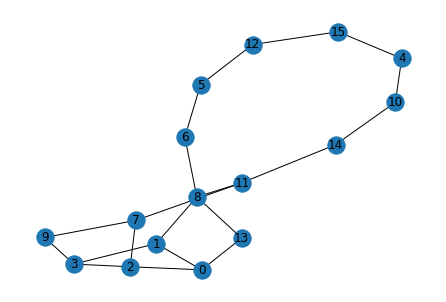

In [11]:
n_vertices = 16
n_arestas = 20
iteracoes = 100
log = Log(title="MCMC")

ultimo_grafo, melhor_grafo, _, _ = metropolis_hastings(n_vertices, n_arestas, iteracoes, score=score_padrao, log=log)
log.save()

draw(ultimo_grafo)

## Execuções

In [52]:
iteracoes = 500

entradas = [(5,6), (5,7), (16,20), (20,25), (28,31), (29,30), (32,50), (32,60)]
cor = ['orange','gray','red', 'green', 'yellow', 'black', 'blue', 'pink']

ultimos = []
melhores = []

resultados = pd.DataFrame()
for n_vertices, n_arestas in entradas:
    ultimo, melhor, metricas, metricas_melhor = metropolis_hastings(n_vertices, n_arestas, iteracoes, score=score_padrao)
    
    resultados_iteracao = pd.DataFrame({
        'entrada':[str((n_vertices,n_arestas))] * iteracoes,
        'iteracao':list(range(len(metricas))),
        'eficiencia':metricas,
    })

    ultimos.append(ultimo)
    melhores.append(melhor)

    resultados = resultados.append(resultados_iteracao, ignore_index=True)
    
resultados

,entrada,iteracao,eficiencia
0,"(5, 6)",0,0.035714
1,"(5, 6)",1,0.035714
2,"(5, 6)",2,0.035714
3,"(5, 6)",3,0.035714
4,"(5, 6)",4,0.035714
...,...,...,...
3995,"(32, 60)",495,0.000385
3996,"(32, 60)",496,0.000384
3997,"(32, 60)",497,0.000385
3998,"(32, 60)",498,0.000388


## Análise de Resultados

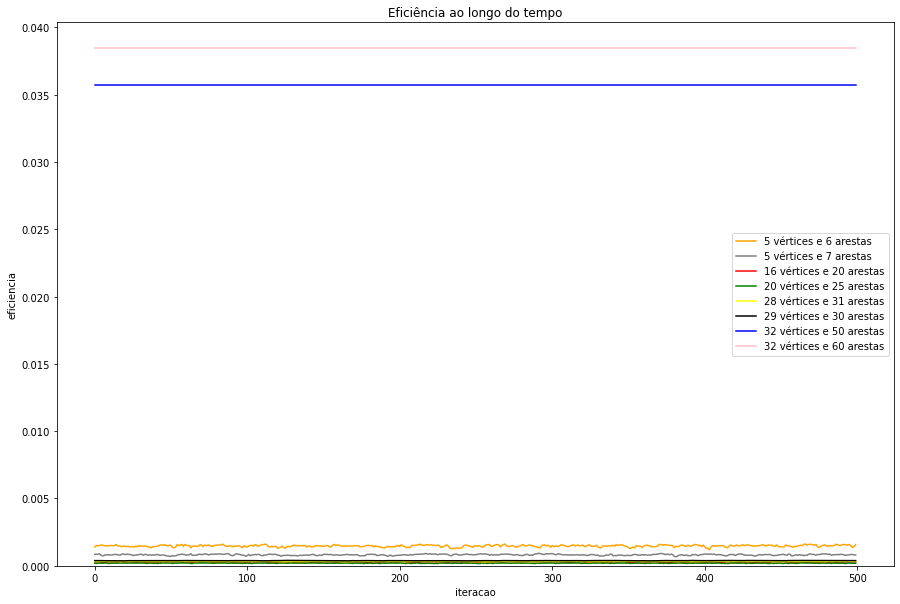

In [53]:
plt.figure(figsize = (15,10))

for i, entrada in enumerate(np.unique(resultados.entrada)):
    res = resultados[resultados.entrada == entrada]
    sns.lineplot(
        x=res.iteracao,
        y=res.eficiencia,
        color=cor[i]
    )

plt.ylim(0)
plt.title("Eficiência ao longo do tempo")
plt.legend(labels=[f"{v} vértices e {a} arestas" for v,a in entradas])
plt.savefig('imgs/mcmc_eficiencia_{}.png'.format(datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))

## Gerando Gráficos

In [16]:
def distribuicao_grau_vertices(grafo):
    nx_grafo = nx.Graph(grafo)
    degrees = []

    for v in range(grafo.shape[0]):
        degrees.append( nx_grafo.degree[v] )

    return degrees

In [55]:
import matplotlib
import matplotlib.pyplot as plot
from matplotlib.ticker import MaxNLocator

def grafico_composto(entrada_idx):
    v, a = entradas[entrada_idx]
    melhor = melhores[entrada_idx]
    ultimo = ultimos[entrada_idx]

    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches((16,9))
    fig.suptitle(f'Resultado para 500 iterações ({v} vértices e {a} arestas)', fontsize=16)

    ax = axes.flatten()

    nx.draw(nx.Graph(melhor), ax=ax[0], with_labels=True)
    ax[0].set_axis_off()
    ax[0].set_title(f'Melhor grafo\nDistância Total: {distancia_total(melhor)}')

    nx.draw(nx.Graph(ultimo), ax=ax[1], with_labels=True)
    ax[1].set_axis_off()
    ax[1].set_title(f'Último grafo\nDistância Total: {distancia_total(ultimo)}')

    graus = distribuicao_grau_vertices(melhor)
    sns.barplot(y=graus,x=list(range(v)), color='blue', ax=ax[2])
    ax[2].set_title('Grau por vértice (melhores)')
    ax[2].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[2].set_ylabel("Grau")
    ax[2].set_xlabel("Índice do Vértice")

    graus = distribuicao_grau_vertices(ultimo)
    sns.barplot(y=graus,x=list(range(v)), color='blue', ax=ax[3])
    ax[3].set_title('Grau por vértice (últimos)')
    ax[3].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[3].set_ylabel("Grau")
    ax[3].set_xlabel("Índice do Vértice")

    plt.savefig('imgs/mcmc_grafos_{}.png'.format(datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))
    plt.show()

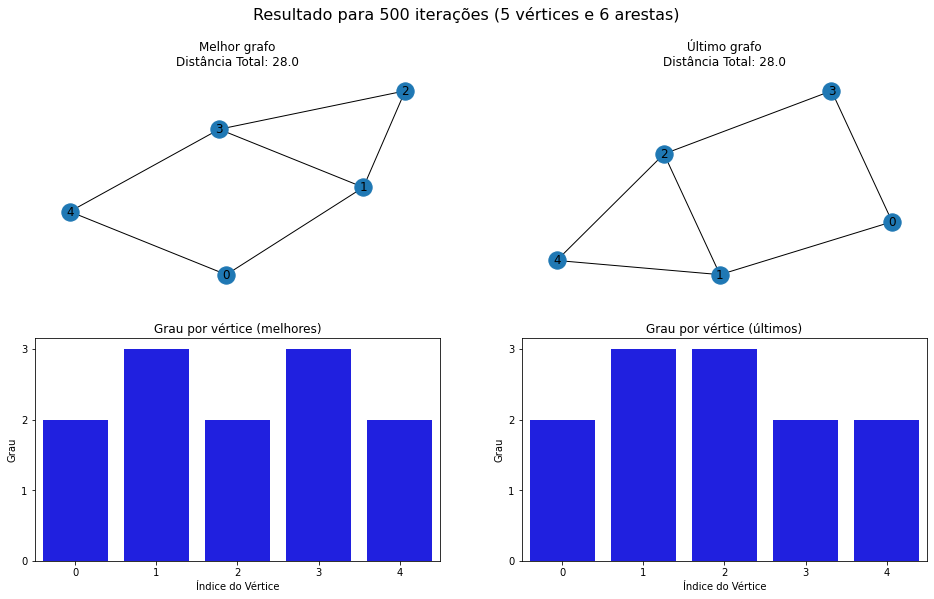

In [56]:
grafico_composto(0)

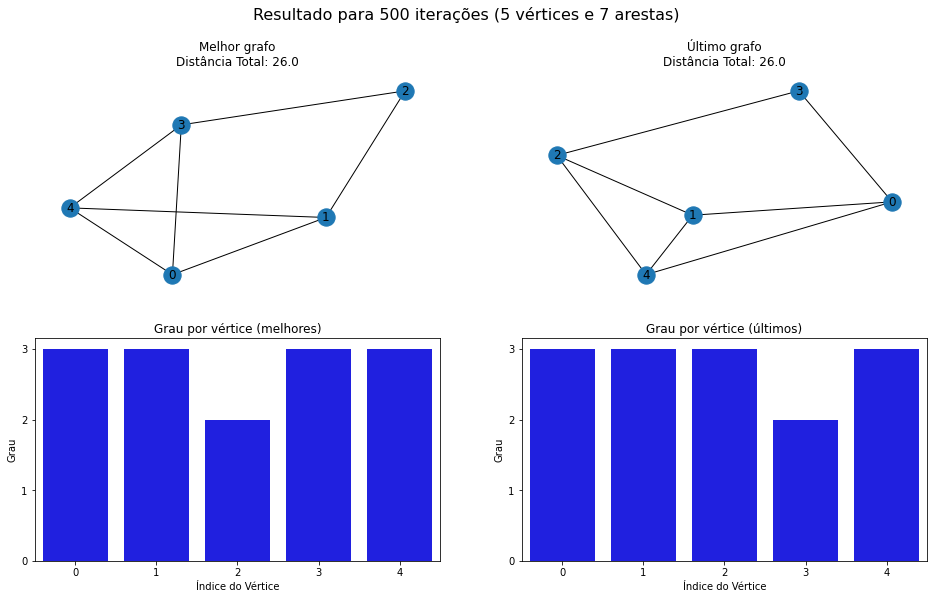

In [57]:
grafico_composto(1)

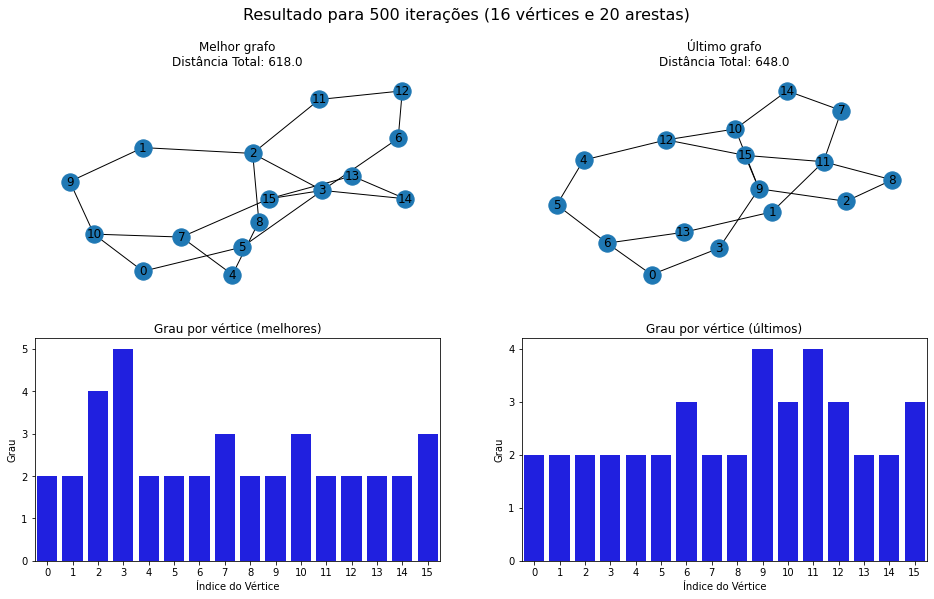

In [59]:
grafico_composto(2)

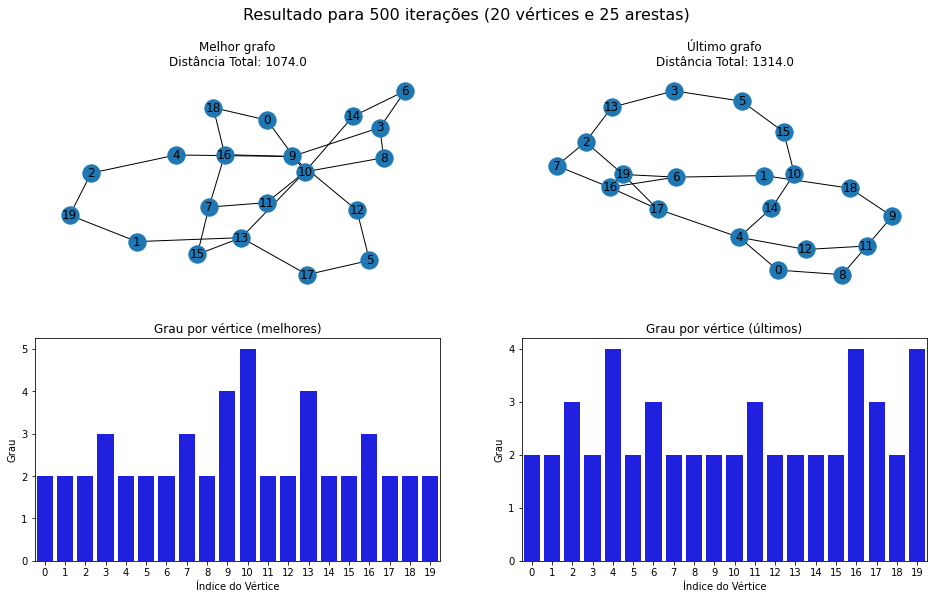

In [60]:
grafico_composto(3)

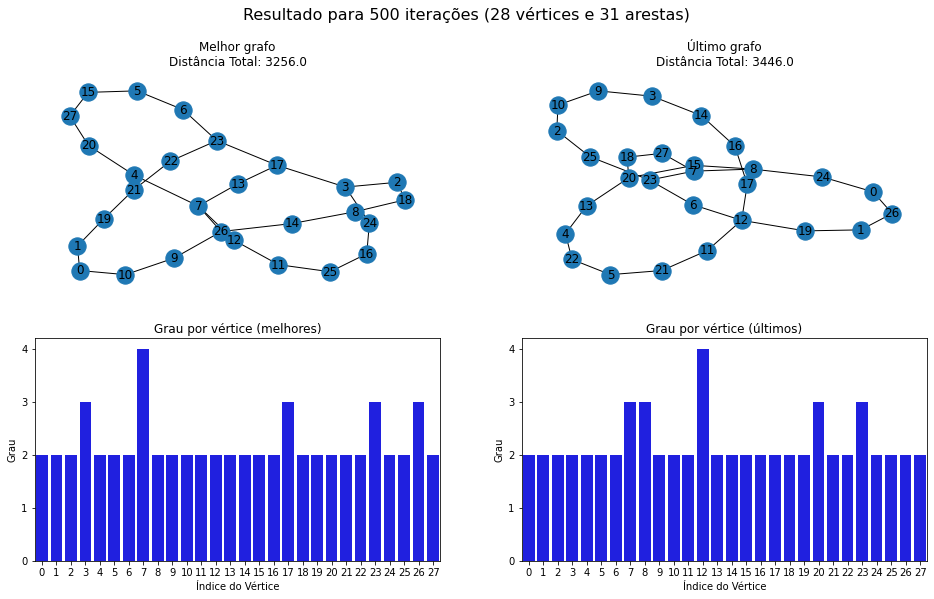

In [61]:
grafico_composto(4)

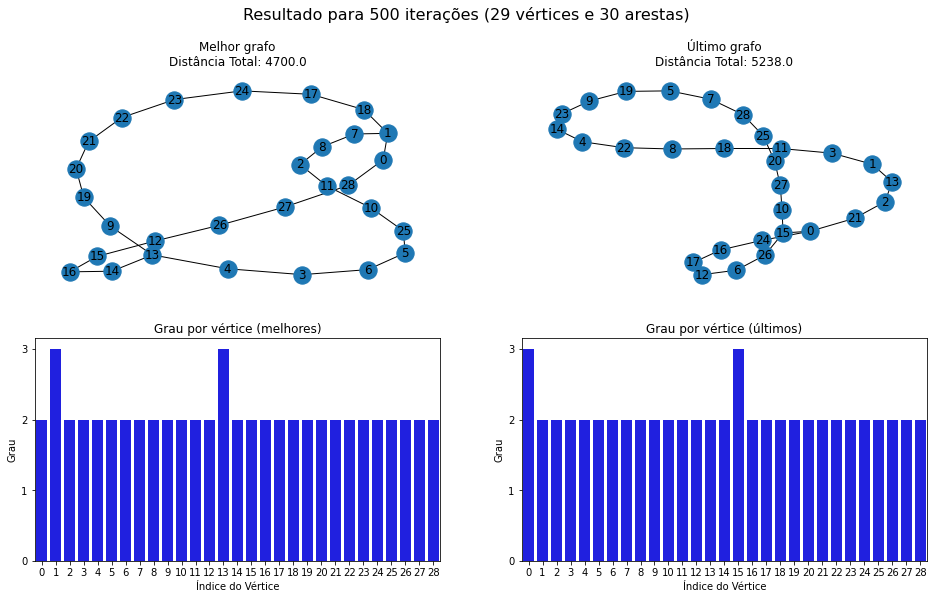

In [62]:
grafico_composto(5)

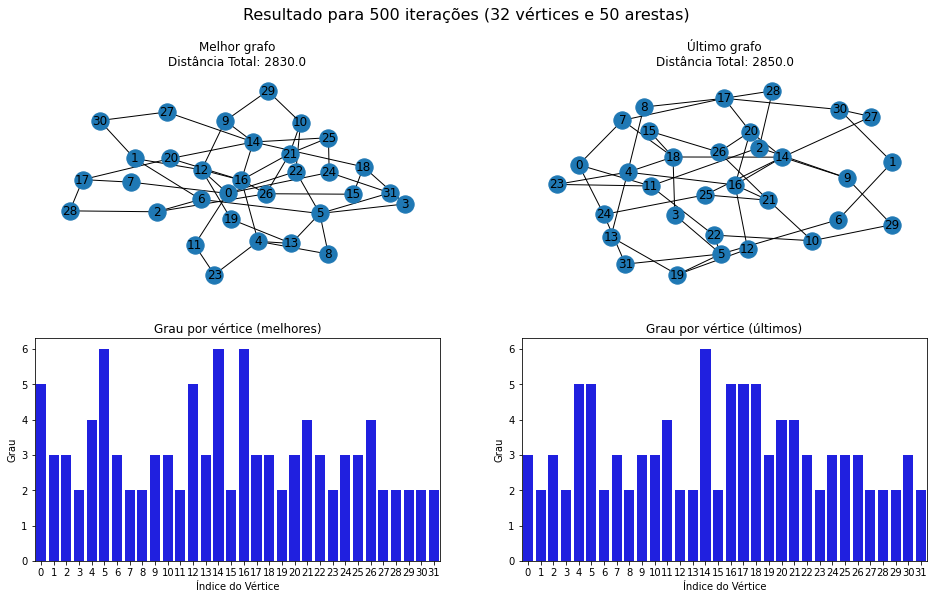

In [63]:
grafico_composto(6)

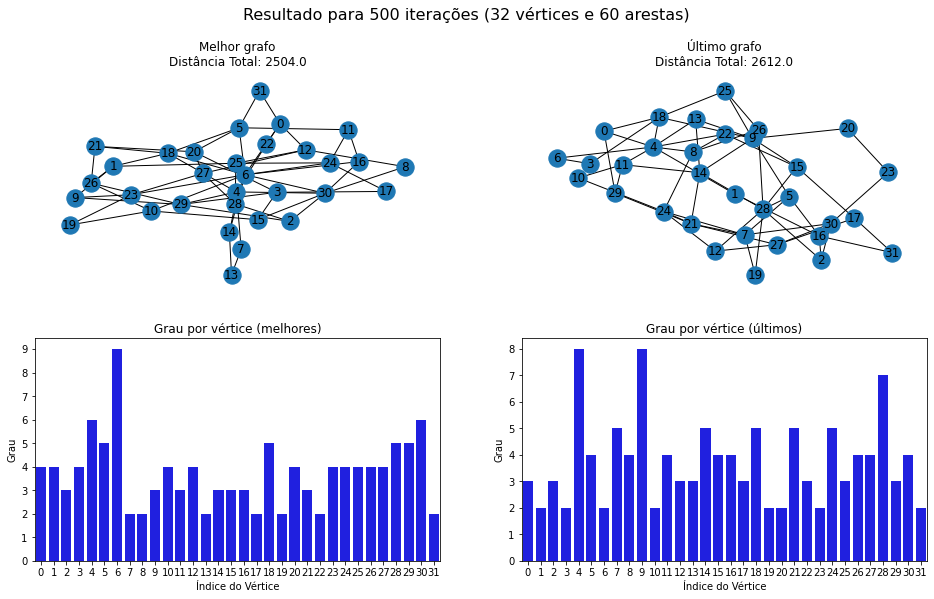

In [64]:
grafico_composto(7)